# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [3]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [4]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Exploratory Data Analysis and Pre-Processing

Let's see how big our training and test datasets are and the types of values they contain.

In [5]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1494, 35)
X_test shape:  (654, 35)


In [6]:
X_train.dtypes.value_counts()

float64    32
int64       2
object      1
dtype: int64

Let's look at the distribution of the variables.

In [7]:
# ### add code here - fix, make smalller charts
# for col in X_train.select_dtypes('float'):
#   # print(col)
#   plt.figure()
#   sns.distplot(X_train[col])

### Correlation Analysis

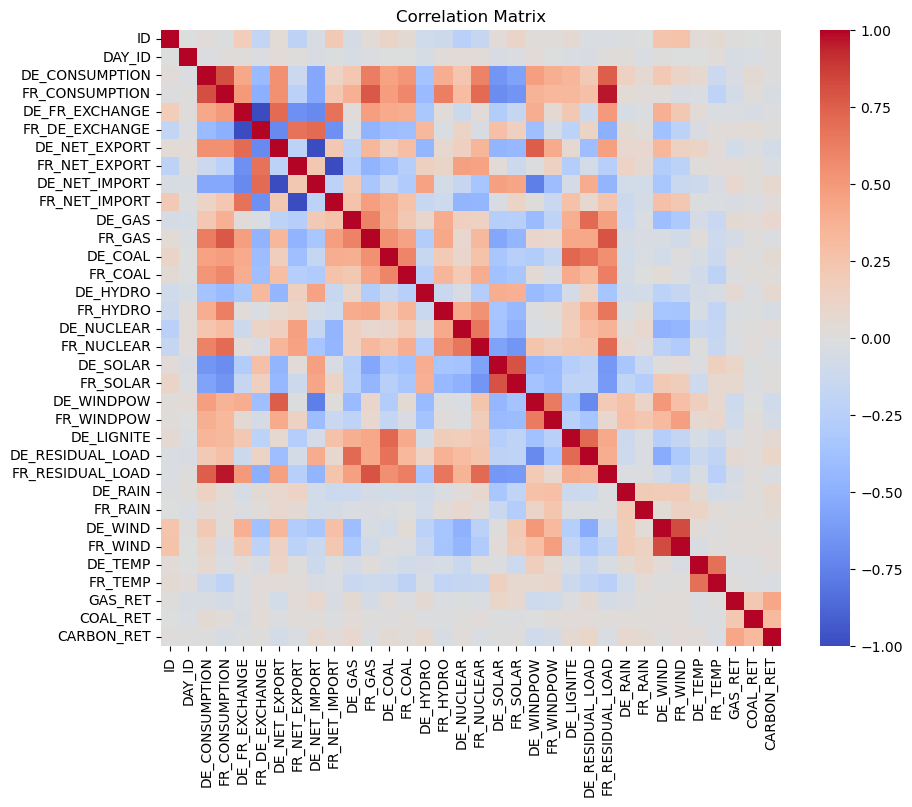

In [8]:
numerical_columns = X_train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We consider +/-0.8 to be a high correlation. We filter for these correlations below to see which columns are highly correlated.

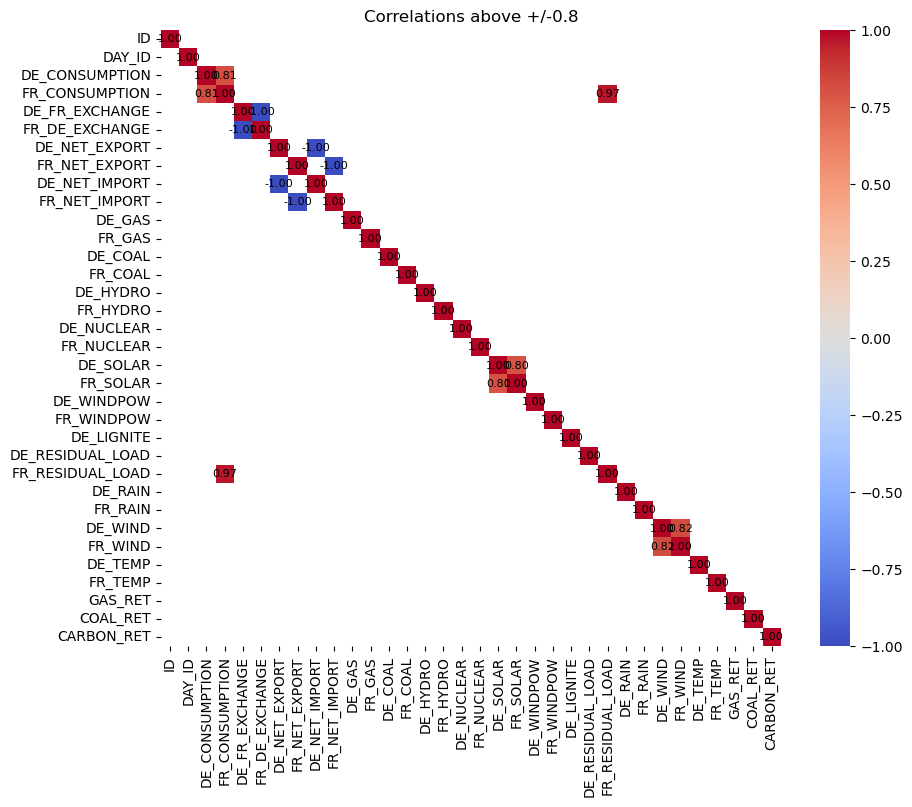

In [9]:
# Filter correlations above 0.8 
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

From the correlation plot, we observe the following correlations:
- FR_CONSUMPTION and FR_RESIDUAL_LOAD
- FR_CONSUMPTION and DE_CONSUMPTION 
- DE_FR_EXCHANGE and FR_DE_EXCHANGE
- DE_NET_IMPORT and DE_NET_EXPORT
- FR_NET_IMPORT and FR_NET_EXPORT
- DE_SOLAR and FR_SOLAR
- DE_WIND and FR_WIND

It is likely that we will need to remove some of these columns.

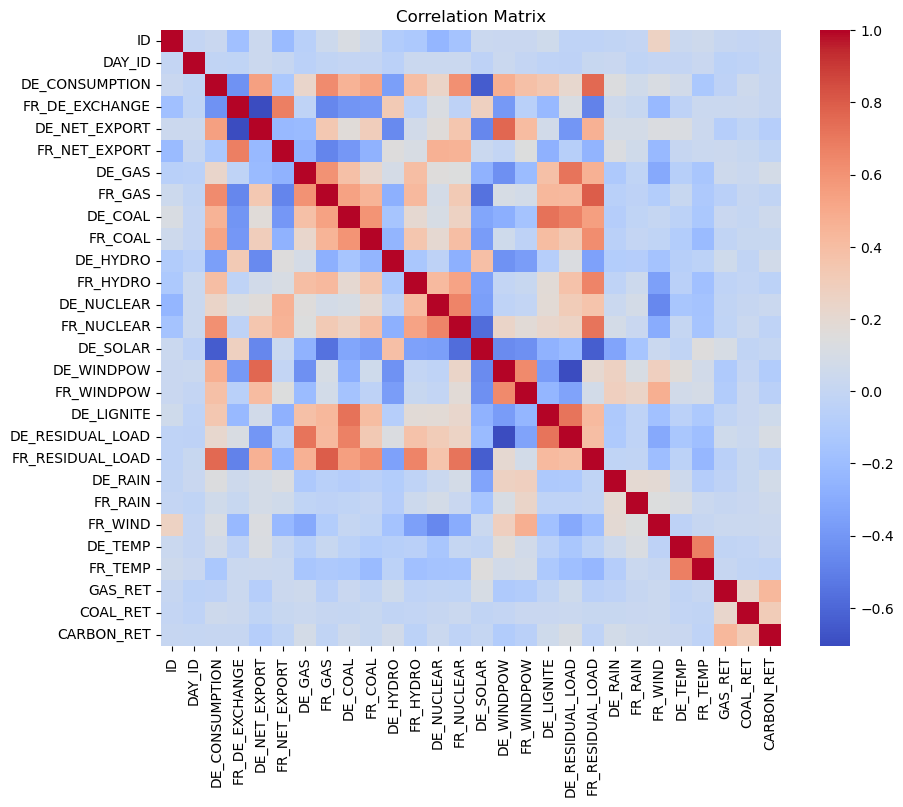

In [10]:
X_train_no_corr = X_train.drop(['COUNTRY', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_SOLAR', 'DE_WIND'], axis=1)
correlation_matrix = X_train_no_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

There are no more correlations above 0.8 as we can see below.

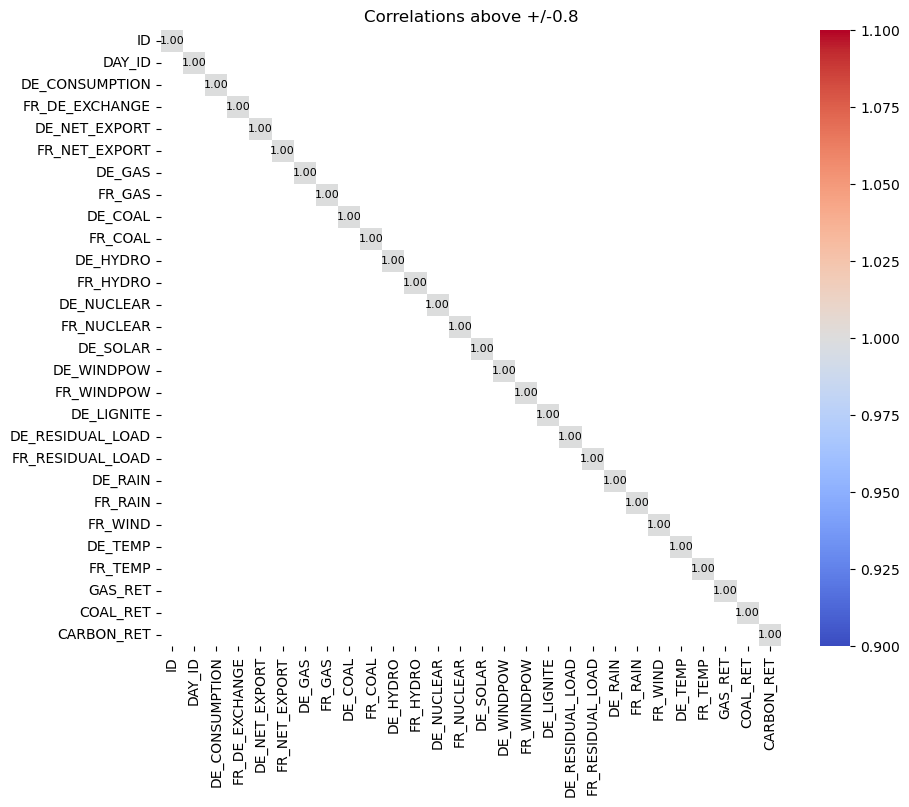

In [11]:
# Filter correlations above 0.8
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

### Missing values

In [12]:
#Count the missing value
X_train.isnull().sum()
#show only the one that is not 0
X_train.isnull().sum()[X_train.isnull().sum() > 0]

DE_FR_EXCHANGE     25
FR_DE_EXCHANGE     25
DE_NET_EXPORT     124
FR_NET_EXPORT      70
DE_NET_IMPORT     124
FR_NET_IMPORT      70
DE_RAIN            94
FR_RAIN            94
DE_WIND            94
FR_WIND            94
DE_TEMP            94
FR_TEMP            94
dtype: int64

- As we can see, there are some numbers are the same amount of missing values
    - DE_FR_EXCHANGE = FR_DE_EXCHANGE
    - DE_NET_EXPORT = - DE_NET_IMPORT
    - FR_NET_EXPORT = - FR_NET_IMPORT

#### Label encoding the country column

In [13]:
X_train['COUNTRY_ID'] = X_train['COUNTRY'].apply(lambda x: 0 if x == 'DE' else 1)
print("The new size", X_train.shape)

The new size (1494, 36)


#### We try 3 different methods for missing values and see how this will impact model results.

1. We will remove the rows with missing values.

In [14]:
Xtrain_copy = X_train.copy()
X_train_dropnull = Xtrain_copy.dropna()
print("The new size", X_train_dropnull.shape)

The new size (1276, 36)


2. Replacing the missing value to 0

In [15]:
#fill the missing value with 0
X_train_fillna = Xtrain_copy.fillna(0)

3. Change the null value to moving average for different country

In [16]:
#replace the missing value with running average according to the DAY_ID for fr_df and de_df
fr_df = X_train[X_train['COUNTRY'] == 'FR']
de_df = X_train[X_train['COUNTRY'] == 'DE']

fr_df = fr_df.sort_values(by='DAY_ID')
de_df = de_df.sort_values(by='DAY_ID')

def fill_with_running_avg(df):
    df.iloc[0] = df.iloc[0].fillna(0)
    
    for column in df.columns[3:]:
        if df[column].dtype == 'float64' or df[column].dtype == 'int64':
            # Calculate the running average excluding the first row
            running_average = df[column].expanding(min_periods=2).mean()
            # Fill missing values with the running average
            df[column] = df[column].fillna(running_average)
    return df

france_df_filled = fill_with_running_avg(fr_df)
germany_df_filled = fill_with_running_avg(de_df)
    
#check the missing value
print('FR missing values:', france_df_filled.isnull().sum().sum())
print('DE missing values:', germany_df_filled.isnull().sum().sum())

FR missing values: 0
DE missing values: 0


In [17]:
#merge fr_df and de_df together
X_train_merge= pd.concat([fr_df, de_df])
print("The new size of X_train_merge: ", X_train_merge.shape)

X_train_merge.head()

The new size of X_train_merge:  (1494, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,...,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1


## Repeating the preprocessing for X_test

In [18]:
X_test_copy = X_test.copy()

# Label encoding the country column
X_test_copy['COUNTRY_ID'] = X_test_copy['COUNTRY'].apply(lambda x: 0 if x == 'DE' else 1)
print("The new size of X_test_copy: ", X_test_copy.shape)

# 1. Dropping the null Values
X_test_dropnull = X_test_copy.dropna()

# 1. Replacing the missing value to 0
X_test_fillna = X_test_copy.fillna(0)

# 3. Change the null value to moving average for different country
fr_test_df = X_test[X_test['COUNTRY'] == 'FR']
de_test_df = X_test[X_test['COUNTRY'] == 'DE']

fr_test_df = fr_test_df.sort_values(by='DAY_ID')
de_test_df = de_test_df.sort_values(by='DAY_ID')

france_test_df_filled = fill_with_running_avg(fr_test_df)
germany_test_df_filled = fill_with_running_avg(de_test_df)

# Merging the two data frames
X_test_merge= pd.concat([germany_test_df_filled, france_test_df_filled])
X_test_merge.head()


The new size of X_test_copy:  (654, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
231,410,4,DE,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
570,562,6,DE,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026
199,750,9,DE,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,...,0.301031,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597
202,802,13,DE,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,...,-0.782514,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399
203,504,24,DE,0.143362,-0.524899,-1.030414,1.030414,-1.005184,0.832404,1.005184,...,-0.635998,0.672093,-0.249368,0.237292,0.682879,0.084806,-0.181177,0.232096,-0.078845,0.190155


## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

### Baseline: Linear Regression - gabri

In [19]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.8%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

### Model 1: Decision Trees - rhianne

### Model 2: Bagging - alix

### Model 3: Random Forest - rhianne

### Model 4: Boosting - vivian

### Model 5: Gradient Boosted Trees - gabri

### Model 6: AdaBoost - alix

### Model 7: XGBoost - vivian

In [24]:
#Train a xgboost model
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#drop the country column for X_train_merge
traindata_xgb = X_train_merge.copy()
traindata_xgb = traindata_xgb.drop(['COUNTRY'], axis=1)

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(traindata_xgb, Y_train_clean, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train, y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [26]:
#test the accuracy of the model
output_xgb = xg_reg.predict(X_test)

#acuracy of the model
def metric_test(output):

    return  spearmanr(output, y_test).correlation

print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_test(output_xgb) ))

Spearman correlation for the test set: -2.5%


In [28]:
output_xgb

array([0.33383793, 0.25600466, 0.30005008, 0.18424594, 0.18424594,
       0.17851931, 0.1949163 , 0.17556389, 0.23586954, 0.17851931,
       0.23318826, 0.34887236, 0.27844238, 0.20266767, 0.17851931,
       0.20266767, 0.26243874, 0.19906087, 0.17851931, 0.17851931,
       0.27870706, 0.17996825, 0.17851931, 0.21558276, 0.27430028,
       0.17851931, 0.26130202, 0.17851931, 0.17851931, 0.17851931,
       0.17851931, 0.28055945, 0.189149  , 0.17851931, 0.17851931,
       0.17851931, 0.5272599 , 0.17851931, 0.189149  , 0.20478751,
       0.17851931, 0.33182055, 0.23586954, 0.21558276, 0.280153  ,
       0.17851931, 0.30690402, 0.24514617, 0.24386503, 0.17851931,
       0.27820966, 0.17851931, 0.17851931, 0.29046285, 0.23838495,
       0.27430028, 0.17851931, 0.23318826, 0.38140774, 0.29978022,
       0.18957102, 0.17851931, 0.17851931, 0.18424594, 0.17851931,
       0.18424594, 0.34347707, 0.20390812, 0.18424594, 0.18424594,
       0.17851931, 0.20266767, 0.17851931, 0.18424594, 0.21682

In [27]:
from sklearn.metrics import accuracy_score

predictions = np.round(output_xgb)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [20]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [21]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)

# Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


/Users/vivianwang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- COUNTRY_ID

  warnings.warn(message, FutureWarning)


ValueError: X has 34 features, but LinearRegression is expecting 35 features as input.

After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
